In [1]:
from aicspylibczi import CziFile
import glob
import os
from pathlib import Path

from brainseg.slide_provider import open_image
from brainseg.slidedata.slides import find_slides_in_dir
from brainseg.slidedata.mask import create_mask, save_mask_as_image, exists_mask_as_image

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
from os.path import basename

In [2]:
STAIN = "SMI32"  # PV, SMI32

root = Path("/media/moi/LaCie/Data/CZI/atlas_folder_backup")

# for cv (nissl)
# root = Path("/media/moi/LaCie/Data/CZI/czi_split5x")

data_root = Path(f"/media/moi/LaCie/Data/slidedata/mask_mashimoto/{STAIN}")

Path(data_root).mkdir(parents=True, exist_ok=True)

slides = find_slides_in_dir(root)
czis = slides

# for all but cv
czis = list(filter(lambda x: STAIN in basename(x), slides))

In [3]:
czis[:5]

['/media/moi/LaCie/Data/CZI/atlas_folder_backup/p50_cv152_ihc198-199/p50_M150_LHRH_199_IA199_SMI32.czi',
 '/media/moi/LaCie/Data/CZI/atlas_folder_backup/p1_cv250_ihc-3/p1_M150_LHRH_003_IA003_SMI32.czi',
 '/media/moi/LaCie/Data/CZI/atlas_folder_backup/p2_cv248_ihc6-7/p2_M150_LHRH_007_IA007_SMI32.czi',
 '/media/moi/LaCie/Data/CZI/atlas_folder_backup/p3_cv246_ihc10-11/p3_M150_LHRH_011_IA011_SMI32.czi',
 '/media/moi/LaCie/Data/CZI/atlas_folder_backup/p4_cv244_ihc14-15/p4_M150_LHRH_015_IA015_SMI32.czi']

In [4]:
patterns = ["_022", "_062", "_118", "_122", "_330", "_354", "_366", "_474", "_490", "_495",
            "_498"]
def has_one_pattern(x):
    for pat in patterns:
        if pat in x:
            return True
    return False

# czis = list(filter(has_one_pattern, czis))

In [5]:
def pick_next(root, slides):
    for slide_path in slides:
        if not exists_mask_as_image(root, slide_path, "mask"):
            return slide_path

## Main loop

In [6]:
from skimage.morphology import area_closing, area_opening

/media/moi/LaCie/Data/CZI/atlas_folder_backup/p31_cv190_ihc122-123/p31_M150_LHRH_123_IA123_SMI32.czi


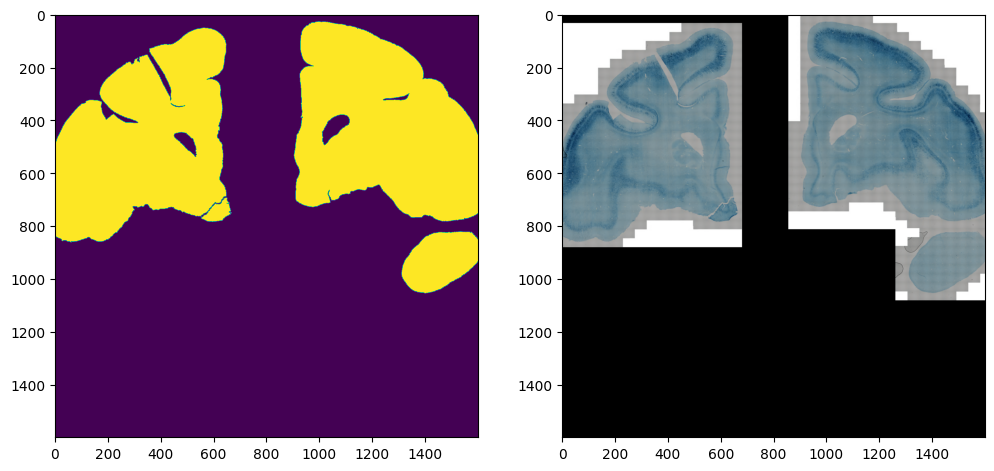

In [69]:
current = pick_next(data_root, czis)
print(current)

slide = CziFile(current)
bbox = slide.get_mosaic_bounding_box()
max_size_fit = bbox.w, bbox.h
img_arr = open_image(slide, (0, 0), 32, 1600)  # rather open patch

f = lambda x: ((x[:, :, 2] - x[:, :, 0]) > 10) & ((x[:, :, 0] + x[:, :, 1] + x[:, :, 2]) < 500) \
                & ((x[:, :, 0] + x[:, :, 1] + x[:, :, 2]) > 1)

func = lambda x: area_opening(area_closing((f(x) * 255).astype(int)))

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.imshow(func(img_arr))
plt.subplot(1, 2, 2)
plt.imshow(img_arr / 255.)

## Validate

In [70]:
mask = create_mask(current, 8, func, step=512)
img = Image.fromarray(mask)
save_mask_as_image(data_root, current, img, name="mask")

In [ ]:
plt.figure(figsize=(16, 16))
plt.imshow(img_arr / 255.)

In [ ]:
current = '/media/nathan/LaCie/Data/CZI/atlas_folder_backup/p101_cv50_ihc406-407/p101_M150_LHRH_406_KP099_NeuN.czi'
print(current)

slide = CziFile(current)
bbox = slide.get_mosaic_bounding_box()
max_size_fit = bbox.w, bbox.h
img_arr = open_image(slide, (0, 0), 64, 1600)  # rather open patch

f = lambda x: (x[:, :, 2] - x[:, :, 0]) > 3

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.imshow(f(img_arr))
plt.subplot(1, 2, 2)
plt.imshow(img_arr / 255.)

In [ ]:
from math import ceil

In [ ]:
def read_scene(slide, origine, downscale, size, scene=0):
    scale = 1 / downscale
    bbox = slide.get_mosaic_scene_bounding_box(scene)
    max_size_fit = bbox.w, bbox.h
    size_down = int(size * downscale)
    size_fit = (
        max(min(max_size_fit[0], origine[0] + size_down) - origine[0], 0),
        max(min(max_size_fit[1], origine[1] + size_down) - origine[1], 0),
    )

    delta_origine = max(0, -origine[0]), max(0, -origine[1])
    delta_origine_down = ceil(delta_origine[0] / downscale), ceil(delta_origine[1] / downscale)

    arr = np.zeros((size, size, 3))
    try:
        image = slide.read_mosaic((origine[0] + bbox.x + delta_origine[0], origine[1] + bbox.y + delta_origine[1],
                                   size_fit[0] - delta_origine[0], size_fit[1] - delta_origine[1]),
                                  C=0, scale_factor=scale)
    except Exception:
        print("failure for", slide, origine, downscale, size, max_size_fit)
        raise
    image = image.reshape(image.shape[-3:])

    # here it's reversed
    arr[delta_origine_down[1]:delta_origine_down[1] + image.shape[0],
    delta_origine_down[0]:delta_origine_down[0] + image.shape[1]] = image
    
    return arr

In [ ]:
current = '/media/nathan/LaCie/Data/CZI/atlas_folder_backup/p101_cv50_ihc406-407/p101_M150_LHRH_406_KP099_NeuN.czi'
print(current)

slide = CziFile(current)
img_arr = read_scene(slide, (0, 0), 64, 1600, scene=1)  # rather open patch

f = lambda x: (x[:, :, 2] - x[:, :, 0]) > 3

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.imshow(f(img_arr))
plt.subplot(1, 2, 2)
plt.imshow(img_arr / 255.)

In [ ]:
d = slide.get_all_scene_bounding_boxes()

In [ ]:
d[0].x, d[0].y, d[0].w, d[0].h

In [ ]:
d[1].x, d[1].y, d[1].w, d[1].h

In [ ]:
max_size_fit

In [ ]:
slide.get_all_scene_bounding_boxes().keys()